In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
from sklearn.preprocessing import KBinsDiscretizer

In [3]:
df=pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

In [4]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [5]:
df.dropna(inplace=True)#remove 177 rows where the age was missing

In [6]:
df.shape

(714, 3)

In [7]:
df.isnull().sum()

Survived    0
Age         0
Fare        0
dtype: int64

In [8]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [9]:
x=df.iloc[:,1:]
y=df.iloc[:,0]

In [10]:
x

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
...,...,...
885,39.0,29.1250
886,27.0,13.0000
887,19.0,30.0000
889,26.0,30.0000


In [11]:
y

0      0
1      1
2      1
3      1
4      0
      ..
885    0
886    0
887    1
889    1
890    0
Name: Survived, Length: 714, dtype: int64

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [13]:
x_train.head(2)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542


In [14]:
clf=DecisionTreeClassifier()

In [15]:
clf.fit(x_train,y_train)

DecisionTreeClassifier()

In [16]:
y_pred=clf.predict(x_test)

In [17]:
accuracy_score(y_test,y_pred)# without applying any transfomation we get this accuracy

0.6293706293706294

In [18]:
np.mean(cross_val_score(DecisionTreeClassifier(),x,y,scoring='accuracy',cv=10))

np.float64(0.6330790297339594)

In [19]:
kbin_age=KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')
kbin_fare=KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')

In [20]:
trf=ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
])

In [21]:
x_train_trf=trf.fit_transform(x_train)
x_test_trf=trf.transform(x_test)

In [22]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
              32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ],
      dtype=object)

In [23]:
trf.named_transformers_['second'].bin_edges_

array([array([  0.    ,   7.25  ,   7.775 ,   7.8958,   8.1583,  10.5   ,
               13.    ,  14.4542,  18.75  ,  26.    ,  26.55  ,  31.275 ,
               51.4792,  76.2917, 108.9   , 512.3292])                   ],
      dtype=object)

In [24]:
output=pd.DataFrame({
    'age':x_train['Age'],
    'age_trf':x_train_trf[:,0],
    'fare':x_train['Fare'],
    'fare_trf':x_train_trf[:,1]
})

In [25]:
output['age_labels']=pd.cut(x=x_train['Age'],
                           bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels']=pd.cut(x=x_train['Fare'],
                           bins=trf.named_transformers_['second'].bin_edges_[0].tolist())

In [26]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
474,22.0,4.0,9.8375,4.0,"(21.0, 23.0]","(8.158, 10.5]"
450,36.0,10.0,27.7500,10.0,"(35.0, 38.0]","(26.55, 31.275]"
253,30.0,8.0,16.1000,7.0,"(28.0, 30.0]","(14.454, 18.75]"
791,16.0,2.0,26.0000,9.0,"(6.0, 16.0]","(18.75, 26.0]"
530,2.0,0.0,26.0000,9.0,"(0.42, 6.0]","(18.75, 26.0]"


In [27]:
clf=DecisionTreeClassifier()
clf.fit(x_train_trf,y_train)
y_pred2=clf.predict(x_test_trf)
accuracy_score(y_test,y_pred2)

0.6363636363636364

In [30]:
def discretize(x, y, bins, strategy):
    # Correct use of strategy (without quotes)
    kbin_age = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy)

    # Apply transformation
    trf = ColumnTransformer([
        ('first', kbin_age, [0]),  # Assuming Age is in column 0
        ('second', kbin_fare, [1])  # Assuming Fare is in column 1
    ])

    x_trf = trf.fit_transform(x)

    # Accuracy score
    print("Cross-validation accuracy:", np.mean(cross_val_score(DecisionTreeClassifier(), x_trf, y, scoring='accuracy', cv=10)))

    # Age histograms
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(x.iloc[:, 0])  # Age
    plt.title('Age - Before')
    plt.subplot(122)
    plt.hist(x_trf[:, 0], color='red')  # Discretized Age
    plt.title('Age - After')
    plt.show()

    # Fare histograms
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.hist(x.iloc[:, 1])  # Fare
    plt.title('Fare - Before')
    plt.subplot(122)
    plt.hist(x_trf[:, 1], color='red')  # Discretized Fare
    plt.title('Fare - After')
    plt.show()
    

    
    

C:\Users\91983\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\91983\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cross-validation accuracy: 0.6584702660406886


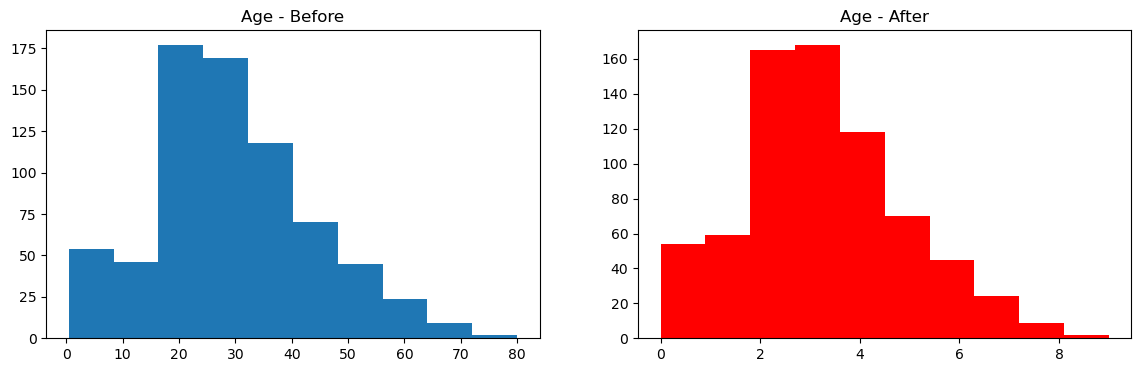

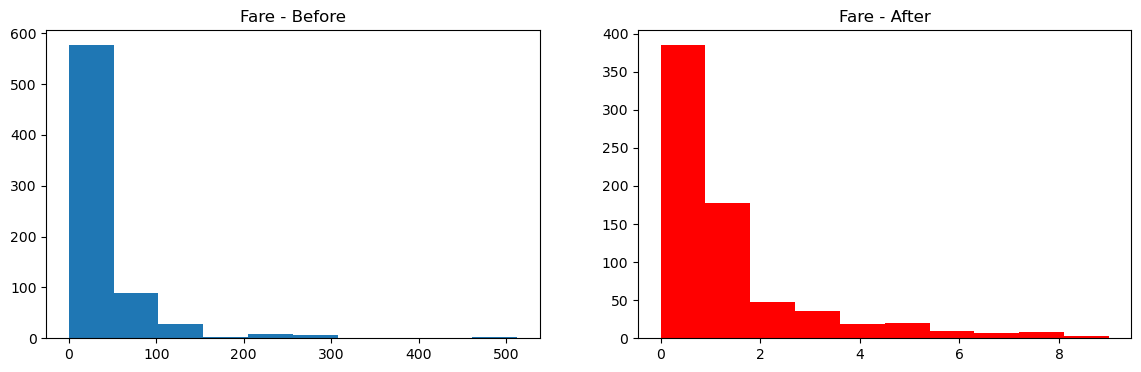

In [33]:
discretize(x,y,10,'k')